# SENTIMENT ANALYSIS BACKEND

In [1]:
#IMPORTS
import pandas as pd

import nltk
from nltk.corpus import stopwords # a,an,the,etc.
from  nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

import gensim

import matplotlib.pyplot as plt

import re
import numpy as np
import logging
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

Using TensorFlow backend.


In [2]:
# DATASET
FILEPATH = "./input/training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.6)

You will need to download Stopwords on the first run if you don't have it already

In [ ]:
nltk.download('stopwords')

In [3]:
df = pd.read_csv(FILEPATH, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Data set loaded.")

Data set loaded.


In [42]:
df.head(20)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
5,NEGATIVE,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew
6,NEGATIVE,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,NEGATIVE,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rains bit bit lol fine t...
8,NEGATIVE,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
9,NEGATIVE,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera


In [4]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [5]:
df.target = df.target.apply(lambda x: decode_sentiment(x))
print("Dataset decoded successfully")

Dataset decoded successfully


In [ ]:
df.head(5)

In [6]:
stopwords = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [7]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
df.text = df.text.apply(lambda x: preprocess(x))
print("Data preprocessing successful.")

Data preprocessing successful.


In [9]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("Dataset split as follows:\n")
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

Dataset split as follows:

TRAIN size: 1280000
TEST size: 320000


In [10]:
documents = [_text.split() for _text in df_train.text] 
print("Successful documenting given data. Length = ", len(documents))

Successful documenting given data. Length =  1280000


In [ ]:
#defining model
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
#building vocab
w2v_model.build_vocab(documents)

#getting vocab size
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print(vocab_size)

#training the vocab 
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

In [11]:
w2v_model = gensim.models.word2vec.Word2Vec.load("model2.w2v")

In [33]:
w2v_model.wv.most_similar("boy")

[('girl', 0.5939455032348633),
 ('kid', 0.46119511127471924),
 ('guy', 0.4250742495059967),
 ('boys', 0.4113749861717224),
 ('baby', 0.3948898911476135),
 ('man', 0.3948540687561035),
 ('brother', 0.3793013095855713),
 ('boyfriend', 0.3651091456413269),
 ('girls', 0.3623187839984894),
 ('son', 0.34856101870536804)]

In [ ]:
#tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [12]:
tokenizer = joblib.load('tokenizer.pkl')

In [13]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [14]:
#encoder

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

LabelEncoder()

In [15]:
y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [17]:
model = load_model("model.h5")

In [18]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [19]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [34]:
predict("hate")

{'label': 'NEGATIVE',
 'score': 0.04564604163169861,
 'elapsed_time': 0.1456761360168457}

In [35]:
entry = input("Make a new Journal Entry = ")

Make a new Journal Entry = hi


In [20]:
def generate_average(entry):
    entry_sentences = entry.split('.')
    score = 0
    for line in entry_sentences:
        score = score + predict(line)['score']
    average = score/len(entry_sentences)
    return average

In [21]:
def generate_result(average):    
    if(average > 0.6):
        print("POSITIVE:",average)
    elif(average < 0.4):
        print("NEGATIVE:",average)
    else:
        print("NEUTRAL:",average)

In [22]:
def read_from_file(filepath):
    fhand = open(filepath,'r')
    scores = []
    for line in fhand:
        scores.append(generate_average(line))
    return scores

In [36]:
y_scores = read_from_file('journal.txt')

In [37]:
days = list(range(len(y_scores)))

In [ ]:
plt.style.available

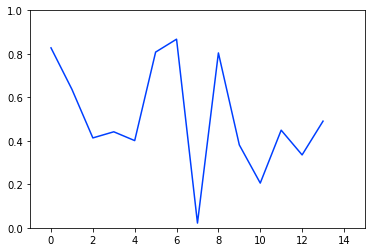

In [38]:
plt.style.use('seaborn-bright')
plt.plot(days, y_scores)
plt.axis([-1, len(days)+1, 0, 1])
plt.show()

In [30]:
predict('I love going to school')

{'label': 'POSITIVE',
 'score': 0.6806764006614685,
 'elapsed_time': 0.1733388900756836}

In [39]:
y_scores = read_from_file('journal.txt')

In [40]:
days = list(range(len(y_scores)))

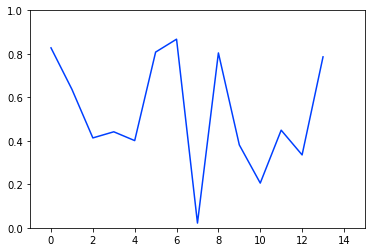

In [41]:
plt.style.use('seaborn-bright')
plt.plot(days, y_scores)
plt.axis([-1, len(days)+1, 0, 1])
plt.show()